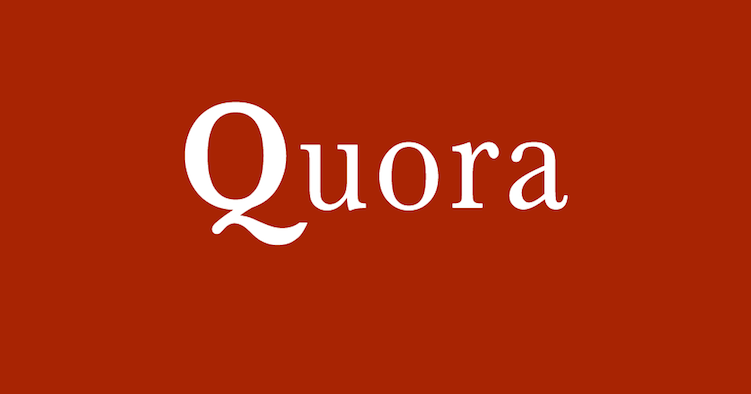

<h1 style="text-align:center;font-size:30px;" > Quora Question Pairs </h1>

<h1> 1. Business Problem </h1>

<h2> 1.1 Description </h2>

<p>Quora is a place to gain and share knowledge—about anything. It’s a platform to ask questions and connect with people who contribute unique insights and quality answers. This empowers people to learn from each other and to better understand the world.</p>
<p>
Over 100 million people visit Quora every month, so it's no surprise that many people ask similarly worded questions. Multiple questions with the same intent can cause seekers to spend more time finding the best answer to their question, and make writers feel they need to answer multiple versions of the same question. Quora values canonical questions because they provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.
</p>
<br>
> Credits: Kaggle 


__ Problem Statement __
- Identify which questions asked on Quora are duplicates of questions that have already been asked. 
- This could be useful to instantly provide answers to questions that have already been answered. 
- We are tasked with predicting whether a pair of questions are duplicates or not. 

<h2> 1.2 Sources/Useful Links</h2>

- Source : https://www.kaggle.com/c/quora-question-pairs
<br><br>____ Useful Links ____
- Discussions : https://www.kaggle.com/anokas/data-analysis-xgboost-starter-0-35460-lb/comments
- Kaggle Winning Solution and other approaches: https://www.dropbox.com/sh/93968nfnrzh8bp5/AACZdtsApc1QSTQc7X0H3QZ5a?dl=0
- Blog 1 : https://engineering.quora.com/Semantic-Question-Matching-with-Deep-Learning
- Blog 2 : https://towardsdatascience.com/identifying-duplicate-questions-on-quora-top-12-on-kaggle-4c1cf93f1c30

<h2>1.3 Real world/Business Objectives and Constraints </h2>

1. The cost of a mis-classification can be very high.
2. You would want a probability of a pair of questions to be duplicates so that you can choose any threshold of choice.
3. No strict latency concerns.
4. Interpretability is partially important.

<h1>2. Machine Learning Probelm </h1>

<h2> 2.1 Data </h2>

<h3> 2.1.1 Data Overview </h3>

<p> 
- Data will be in a file Train.csv <br>
- Train.csv contains 5 columns : qid1, qid2, question1, question2, is_duplicate <br>
- Size of Train.csv - 60MB <br>
- Number of rows in Train.csv = 404,290
</p>

<h3> 2.1.2 Example Data point </h3>

<pre>
"id","qid1","qid2","question1","question2","is_duplicate"
"0","1","2","What is the step by step guide to invest in share market in india?","What is the step by step guide to invest in share market?","0"
"1","3","4","What is the story of Kohinoor (Koh-i-Noor) Diamond?","What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?","0"
"7","15","16","How can I be a good geologist?","What should I do to be a great geologist?","1"
"11","23","24","How do I read and find my YouTube comments?","How can I see all my Youtube comments?","1"
</pre>

<h2> 2.2 Mapping the real world problem to an ML problem </h2>

<h3> 2.2.1 Type of Machine Leaning Problem </h3>

<p> It is a binary classification problem, for a given pair of questions we need to predict if they are duplicate or not. </p>

<h3> 2.2.2 Performance Metric </h3>

Source: https://www.kaggle.com/c/quora-question-pairs#evaluation

Metric(s): 
* log-loss : https://www.kaggle.com/wiki/LogarithmicLoss
* Binary Confusion Matrix

<h2> 2.3 Train and Test Construction </h2>

<p>  </p>
<p> We build train and test by randomly splitting in the ratio of 70:30 or 80:20 whatever we choose as we have sufficient points to work with. </p>

<h1>3. Exploratory Data Analysis </h1>

In [52]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc
from wordcloud import WordCloud, STOPWORDS
import re
import nltk
from nltk.corpus import stopwords
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings
warnings.filterwarnings("ignore")

<h2> 3.1 Reading data and basic stats </h2>

In [53]:
df = pd.read_csv(r"C:\Users\hp\Downloads\train.csv")

print("Number of data points:",df.shape[0])

Number of data points: 404290


In [54]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
id              404290 non-null int64
qid1            404290 non-null int64
qid2            404290 non-null int64
question1       404289 non-null object
question2       404288 non-null object
is_duplicate    404290 non-null int64
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


We are given a minimal number of data fields here, consisting of:

- id:  Looks like a simple rowID
- qid{1, 2}:  The unique ID of each question in the pair
- question{1, 2}:  The actual textual contents of the questions.
- is_duplicate:  The label that we are trying to predict - whether the two questions are duplicates of each other.

<h3> 3.2.1 Distribution of data points among output classes</h3>
- Number of duplicate(smilar) and non-duplicate(non similar) questions

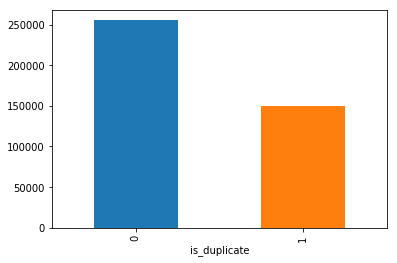

In [56]:
df.groupby("is_duplicate")['id'].count().plot.bar()

In [57]:
print('~> Total number of question pairs for training:\n   {}'.format(len(df)))

~> Total number of question pairs for training:
   404290


In [58]:
print('~> Question pairs are not Similar (is_duplicate = 0):\n   {}%'.format(100 - round(df['is_duplicate'].mean()*100, 2)))
print('\n~> Question pairs are Similar (is_duplicate = 1):\n   {}%'.format(round(df['is_duplicate'].mean()*100, 2)))

~> Question pairs are not Similar (is_duplicate = 0):
   63.08%

~> Question pairs are Similar (is_duplicate = 1):
   36.92%


In [59]:
qids = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())

In [60]:
qids.head()

0    1
1    3
2    5
3    7
4    9
dtype: int64

<h3> 3.2.2 Number of unique questions </h3>

In [61]:
qids = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
unique_qs = len(np.unique(qids))
qs_morethan_onetime = np.sum(qids.value_counts() > 1)
print ('Total number of  Unique Questions are: {}\n'.format(unique_qs))
#print len(np.unique(qids))

print ('Number of unique questions that appear more than one time: {} ({}%)\n'.format(qs_morethan_onetime,qs_morethan_onetime/unique_qs*100))

print ('Max number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

q_vals=qids.value_counts()

q_vals=q_vals.values

Total number of  Unique Questions are: 537933

Number of unique questions that appear more than one time: 111780 (20.77953945937505%)

Max number of times a single question is repeated: 157



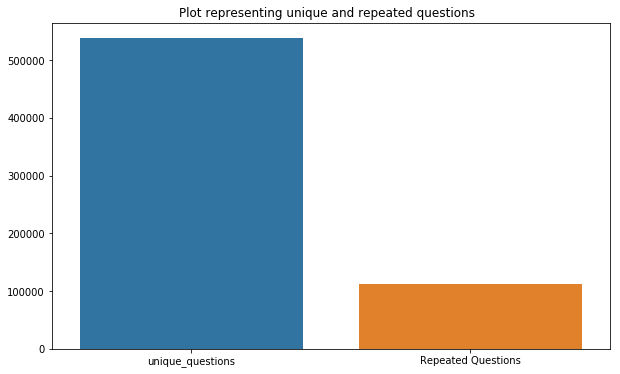

In [62]:

x = ["unique_questions" , "Repeated Questions"]
y =  [unique_qs , qs_morethan_onetime]

plt.figure(figsize=(10, 6))
plt.title ("Plot representing unique and repeated questions  ")
sns.barplot(x,y)
plt.show()

<h3>3.2.3 Checking for Duplicates </h3>

In [63]:
pair_duplicates = df[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()

In [64]:
#checking whether there are any repeated pair of questions

pair_duplicates = df[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()

print ("Number of duplicate questions",(pair_duplicates).shape[0] - df.shape[0])

Number of duplicate questions 0


<h3> 3.2.4 Number of occurrences of each question </h3>

Maximum number of times a single question is repeated: 157



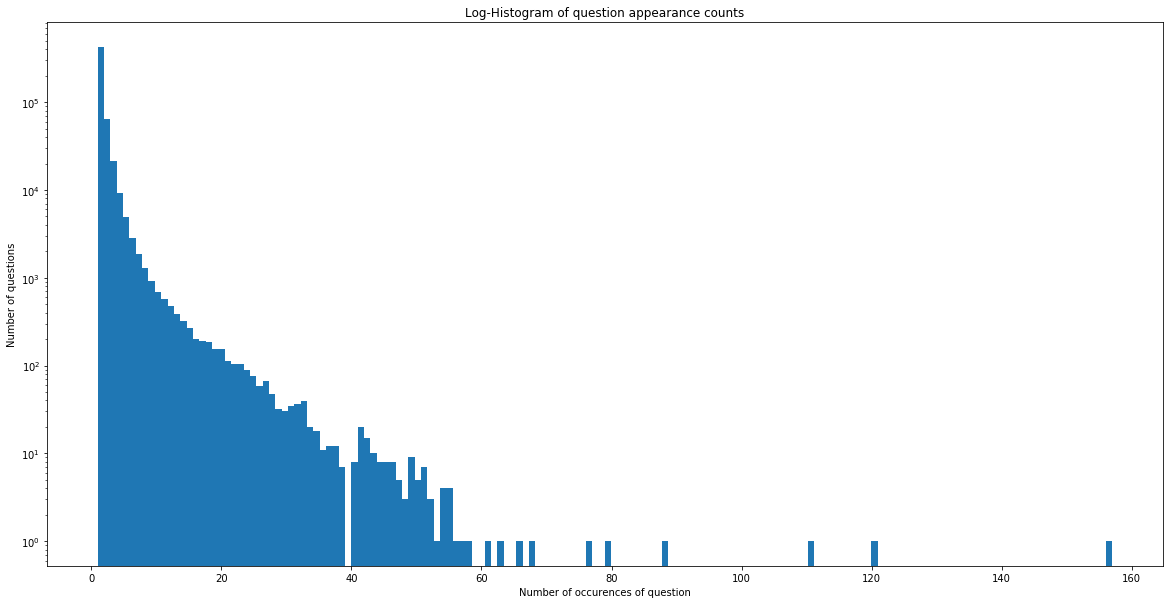

In [65]:
plt.figure(figsize=(20, 10))

plt.hist(qids.value_counts(), bins=160)

plt.yscale('log', nonposy='clip')

plt.title('Log-Histogram of question appearance counts')

plt.xlabel('Number of occurences of question')

plt.ylabel('Number of questions')

print ('Maximum number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

<h3> 3.2.5 Checking for NULL values </h3>

In [68]:
#Checking whether there are any rows with null values
nan_rows = df[df.isnull().any(1)]
print (nan_rows)

            id    qid1    qid2                         question1  \
105780  105780  174363  174364    How can I develop android app?   
201841  201841  303951  174364  How can I create an Android app?   
363362  363362  493340  493341                               NaN   

                                                question2  is_duplicate  
105780                                                NaN             0  
201841                                                NaN             0  
363362  My Chinese name is Haichao Yu. What English na...             0  


- There are two rows with null values in question2 

In [69]:
# Filling the null values with ' '
df = df.fillna('')
nan_rows = df[df.isnull().any(1)]
print (nan_rows)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


<h2>3.3 Basic Feature Extraction (before cleaning) </h2>

Let us now construct a few features like:
 - ____freq_qid1____ = Frequency of qid1's
 - ____freq_qid2____ = Frequency of qid2's 
 - ____q1len____ = Length of q1
 - ____q2len____ = Length of q2
 - ____q1_n_words____ = Number of words in Question 1
 - ____q2_n_words____ = Number of words in Question 2
 - ____word_Common____ = (Number of common unique words in Question 1 and Question 2)
 - ____word_Total____ =(Total num of words in Question 1 + Total num of words in Question 2)
 - ____word_share____ = (word_common)/(word_Total)
 - ____freq_q1+freq_q2____ = sum total of frequency of qid1 and qid2 
 - ____freq_q1-freq_q2____ = absolute difference of frequency of qid1 and qid2 

In [70]:
if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    df = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
else:
    df['freq_qid1'] = df.groupby('qid1')['qid1'].transform('count') 
    df['freq_qid2'] = df.groupby('qid2')['qid2'].transform('count')
    df['q1len'] = df['question1'].str.len() 
    df['q2len'] = df['question2'].str.len()
    df['q1_n_words'] = df['question1'].apply(lambda row: len(row.split(" ")))
    df['q2_n_words'] = df['question2'].apply(lambda row: len(row.split(" ")))

    def normalized_word_Common(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)
    df['word_Common'] = df.apply(normalized_word_Common, axis=1)

    def normalized_word_Total(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * (len(w1) + len(w2))
    df['word_Total'] = df.apply(normalized_word_Total, axis=1)

    def normalized_word_share(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
    df['word_share'] = df.apply(normalized_word_share, axis=1)

    df['freq_q1+q2'] = df['freq_qid1']+df['freq_qid2']
    df['freq_q1-q2'] = abs(df['freq_qid1']-df['freq_qid2'])

    df.to_csv("df_fe_without_preprocessing_train.csv", index=False)

df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


<h3> 3.3.1 Analysis of some of the extracted features </h3>

- Here are some questions have only one single words.

In [71]:
print ("Minimum length of the questions in question1 : " , min(df['q1_n_words']))

print ("Minimum length of the questions in question2 : " , min(df['q2_n_words']))

print ("Number of Questions with minimum length [question1] :", df[df['q1_n_words']== 1].shape[0])
print ("Number of Questions with minimum length [question2] :", df[df['q2_n_words']== 1].shape[0])

Minimum length of the questions in question1 :  1
Minimum length of the questions in question2 :  1
Number of Questions with minimum length [question1] : 67
Number of Questions with minimum length [question2] : 24


<h4> 3.3.1.1 Feature: word_share </h4>

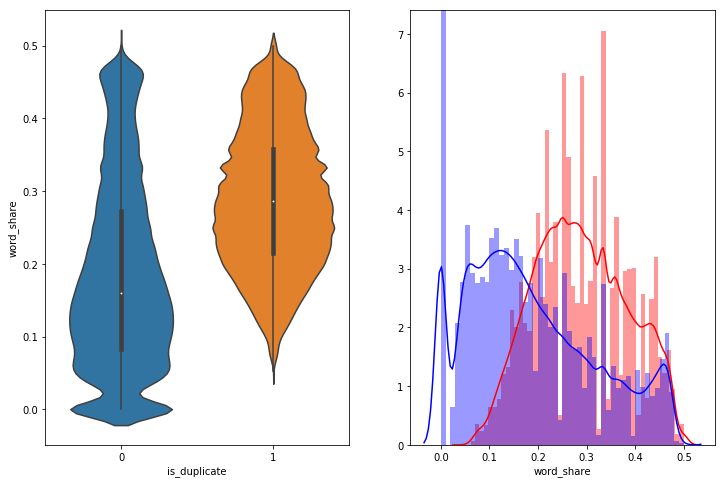

In [73]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_share', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_share'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_share'][0:] , label = "0" , color = 'blue' )
plt.show()

- The distributions for normalized word_share have some overlap on the far right-hand side, i.e., there are quite a lot of questions with high word similarity
- The average word share and Common no. of words of qid1 and qid2 is more when they are duplicate(Similar)

<h4> 3.3.1.2 Feature: word_Common </h4>

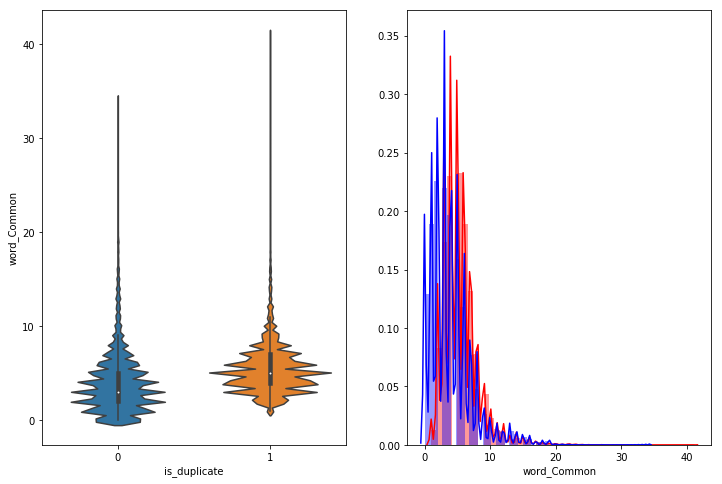

In [74]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_Common', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_Common'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_Common'][0:] , label = "0" , color = 'blue' )
plt.show()

<p> The distributions of the word_Common feature in similar and non-similar questions are highly overlapping </p>

### 3.3.1.3 : EDA: Advanced Feature Extraction.


In [75]:
#https://stackoverflow.com/questions/12468179/unicodedecodeerror-utf8-codec-cant-decode-byte-0x9c
if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    df = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
    df = df.fillna('')
    df.head()
else:
    print("get df_fe_without_preprocessing_train.csv from drive or run the previous notebook")

In [76]:
df.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3


<h2> 3.4 Preprocessing of Text </h2>

- Preprocessing:
    - Removing html tags 
    - Removing Punctuations
    - Performing stemming
    - Removing Stopwords
    - Expanding contractions etc.

In [78]:
# To get the results in 4 decemal points
SAFE_DIV = 0.0001 

STOP_WORDS = stopwords.words("english")


def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    
    porter = PorterStemmer()
    pattern = re.compile('\W')
    
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    
    
    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()
               
    
    return x
    

- Function to Compute and get the features : With 2 parameters of Question 1 and Question 2

<h2> 3.5 Advanced Feature Extraction (NLP and Fuzzy Features) </h2>

Definition:
- __Token__: You get a token by splitting sentence a space
- __Stop_Word__ : stop words as per NLTK.
- __Word__ : A token that is not a stop_word


Features:
- __cwc_min__ :  Ratio of common_word_count to min lenghth of word count of Q1 and Q2 <br>cwc_min = common_word_count / (min(len(q1_words), len(q2_words))
<br>
<br>
- __cwc_max__ :  Ratio of common_word_count to max lenghth of word count of Q1 and Q2 <br>cwc_max = common_word_count / (max(len(q1_words), len(q2_words))
<br>
<br>
- __csc_min__ :  Ratio of common_stop_count to min lenghth of stop count of Q1 and Q2 <br> csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops))
<br>
<br>
- __csc_max__ :  Ratio of common_stop_count to max lenghth of stop count of Q1 and Q2<br>csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops))
<br>
<br>
- __ctc_min__ :  Ratio of common_token_count to min lenghth of token count of Q1 and Q2<br>ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens))
<br>
<br>

- __ctc_max__ :  Ratio of common_token_count to max lenghth of token count of Q1 and Q2<br>ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens))
<br>
<br>
        
- __last_word_eq__ :  Check if First word of both questions is equal or not<br>last_word_eq = int(q1_tokens[-1] == q2_tokens[-1])
<br>
<br>

- __first_word_eq__ :  Check if First word of both questions is equal or not<br>first_word_eq = int(q1_tokens[0] == q2_tokens[0])
<br>
<br>
        
- __abs_len_diff__ :  Abs. length difference<br>abs_len_diff = abs(len(q1_tokens) - len(q2_tokens))
<br>
<br>

- __mean_len__ :  Average Token Length of both Questions<br>mean_len = (len(q1_tokens) + len(q2_tokens))/2
<br>
<br>


- __fuzz_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>

- __fuzz_partial_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_sort_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_set_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>





- __longest_substr_ratio__ :  Ratio of length longest common substring to min lenghth of token count of Q1 and Q2<br>longest_substr_ratio = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens))


In [79]:

def get_token_features(q1, q2):
    token_features = [0.0]*10
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
    return token_features

# get the Longest Common sub string

def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)

def extract_features(df):
    # preprocessing each question
    df["question1"] = df["question1"].fillna("").apply(preprocess)
    df["question2"] = df["question2"].fillna("").apply(preprocess)

    print("token features...")
    
    # Merging Features with dataset
    
    token_features = df.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)
    
    df["cwc_min"]       = list(map(lambda x: x[0], token_features))
    df["cwc_max"]       = list(map(lambda x: x[1], token_features))
    df["csc_min"]       = list(map(lambda x: x[2], token_features))
    df["csc_max"]       = list(map(lambda x: x[3], token_features))
    df["ctc_min"]       = list(map(lambda x: x[4], token_features))
    df["ctc_max"]       = list(map(lambda x: x[5], token_features))
    df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    df["mean_len"]      = list(map(lambda x: x[9], token_features))
   
    #Computing Fuzzy Features and Merging with Dataset
    
    # do read this blog: http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
    # https://stackoverflow.com/questions/31806695/when-to-use-which-fuzz-function-to-compare-2-strings
    # https://github.com/seatgeek/fuzzywuzzy
    print("fuzzy features..")

    df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    # The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and 
    # then joining them back into a string We then compare the transformed strings with a simple ratio().
    df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
    return df

In [81]:
if os.path.isfile('nlp_features_train.csv'):
    df = pd.read_csv("nlp_features_train.csv",encoding='latin-1')
    df.fillna('')
else:
    print("Extracting features for train:")
    df = pd.read_csv("train.csv")
    df = extract_features(df)
    df.to_csv("nlp_features_train.csv", index=False)
df.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.999980,0.833319,0.999983,0.999983,...,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,0.799984,0.399996,0.749981,0.599988,...,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154


<h3>3.5.1 Analysis of extracted features </h3>

<h4> 3.5.1.1 Plotting Word clouds</h4>

- Creating Word Cloud of Duplicates and Non-Duplicates Question pairs
- We can observe the most frequent occuring words

In [82]:
df_duplicate = df[df['is_duplicate'] == 1]
dfp_nonduplicate = df[df['is_duplicate'] == 0]

# Converting 2d array of q1 and q2 and flatten the array: like {{1,2},{3,4}} to {1,2,3,4}
p = np.dstack([df_duplicate["question1"], df_duplicate["question2"]]).flatten()
n = np.dstack([dfp_nonduplicate["question1"], dfp_nonduplicate["question2"]]).flatten()

print ("Number of data points in class 1 (duplicate pairs) :",len(p))
print ("Number of data points in class 0 (non duplicate pairs) :",len(n))

#Saving the np array into a text file
np.savetxt('train_p.txt', p, delimiter=' ', fmt='%s',encoding="utf8")
np.savetxt('train_n.txt', n, delimiter=' ', fmt='%s',encoding="utf8")

Number of data points in class 1 (duplicate pairs) : 298526
Number of data points in class 0 (non duplicate pairs) : 510054


In [83]:
# reading the text files and removing the Stop Words:
from nltk.corpus import stopwords
d = os.path.dirname('.')

textp_w = open(os.path.join(d, 'train_p.txt'),encoding = 'utf-8').read()
textn_w = open(os.path.join(d, 'train_n.txt'),encoding = 'utf-8').read()
stopwords = set(STOPWORDS)
stopwords.add("said")
stopwords.add("br")
stopwords.add(" ")
stopwords.remove("not")

stopwords.remove("no")
#stopwords.remove("good")
#stopwords.remove("love")
stopwords.remove("like")
#stopwords.remove("best")
#stopwords.remove("!")

print ("Total number of words in duplicate pair questions :",len(textp_w))
print ("Total number of words in non duplicate pair questions :",len(textn_w))

Total number of words in duplicate pair questions : 16110763
Total number of words in non duplicate pair questions : 33201102


__ Word Clouds generated from  duplicate pair question's text __

Word Cloud for Duplicate Question pairs


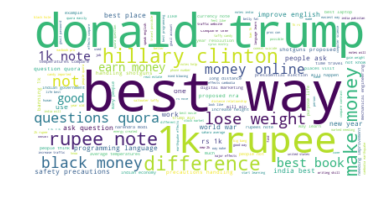

In [84]:
wc = WordCloud(background_color="white", max_words=len(textp_w), stopwords=stopwords)
wc.generate(textp_w)
print ("Word Cloud for Duplicate Question pairs")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

__ Word Clouds generated from non duplicate pair question's text __

Word Cloud for non-Duplicate Question pairs:


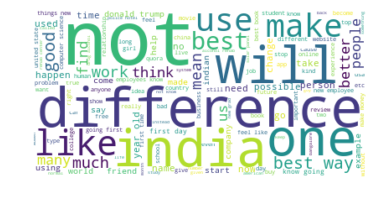

In [85]:
wc = WordCloud(background_color="white", max_words=len(textn_w),stopwords=stopwords)
# generate word cloud
wc.generate(textn_w)
print ("Word Cloud for non-Duplicate Question pairs:")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

<h4> 3.5.1.2 Pair plot of features ['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'] </h4>

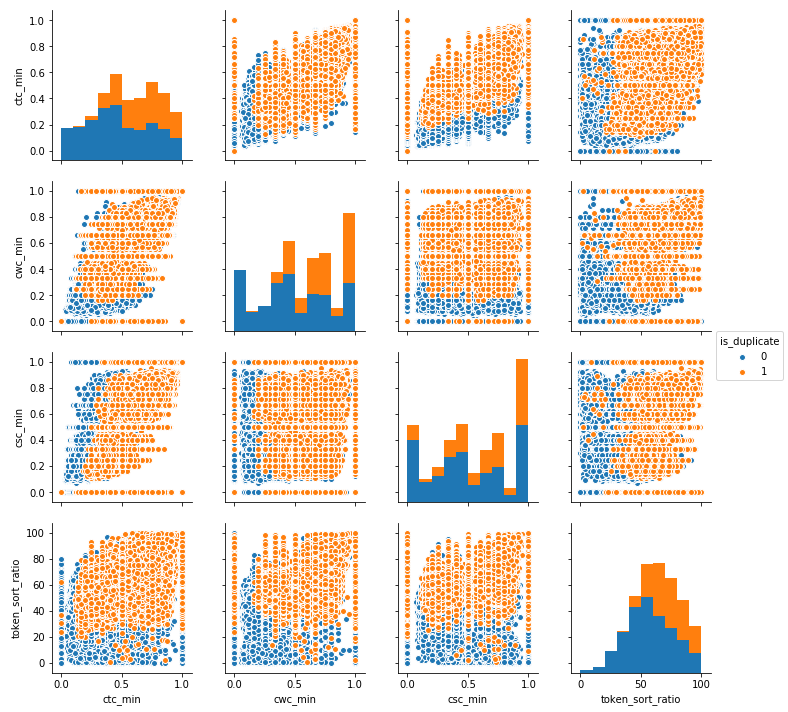

In [86]:
n = df.shape[0]
sns.pairplot(df[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'is_duplicate']][0:n], hue='is_duplicate', vars=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'])
plt.show()

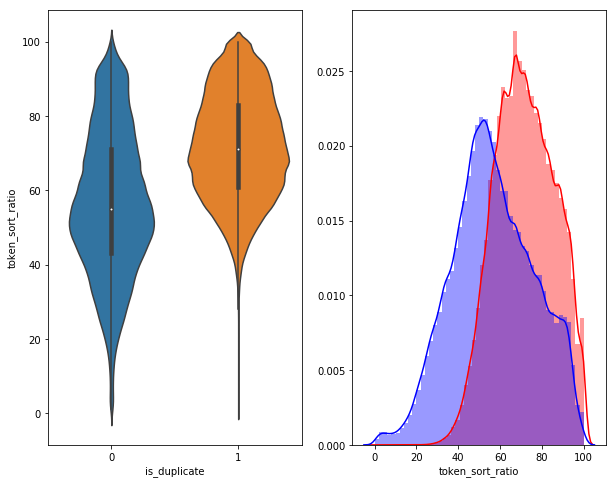

In [87]:
# Distribution of the token_sort_ratio
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'token_sort_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['token_sort_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['token_sort_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

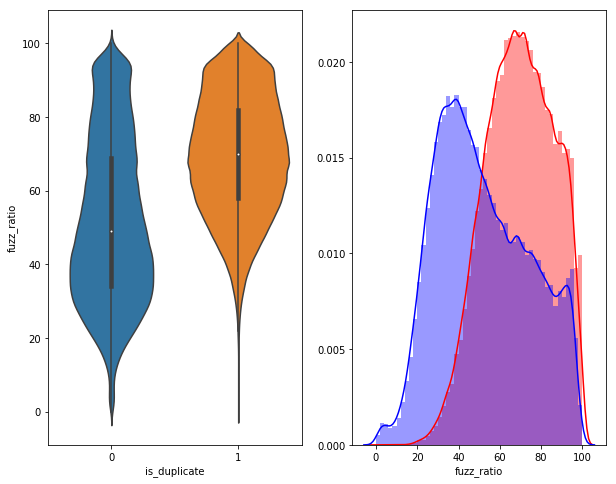

In [88]:
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'fuzz_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['fuzz_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['fuzz_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

<h3>3.5.2 Visualization </h3>

In [89]:
# Using TSNE for Dimentionality reduction for 15 Features(Generated after cleaning the data) to 3 dimention

from sklearn.preprocessing import MinMaxScaler

dfp_subsampled = df[0:5000]
X = MinMaxScaler().fit_transform(dfp_subsampled[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio' , 'longest_substr_ratio']])
y = dfp_subsampled['is_duplicate'].values

In [90]:

from sklearn.manifold import TSNE
tsne2d = TSNE(
    n_components=2,
    init='random',
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.041s...
[t-SNE] Computed neighbors for 5000 samples in 1.106s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.130446
[t-SNE] Computed conditional probabilities in 0.568s
[t-SNE] Iteration 50: error = 81.2897949, gradient norm = 0.0455700 (50 iterations in 18.231s)
[t-SNE] Iteration 100: error = 70.6164398, gradient norm = 0.0095177 (50 iterations in 8.007s)
[t-SNE] Iteration 150: error = 68.9172134, gradient norm = 0.0056736 (50 iterations in 7.331s)
[t-SNE] Iteration 200: error = 68.1004639, gradient norm = 0.0049672 (50 iterations in 7.534s)
[t-SNE] Iteration 250: error = 67.5914536, gradient norm = 0.003970

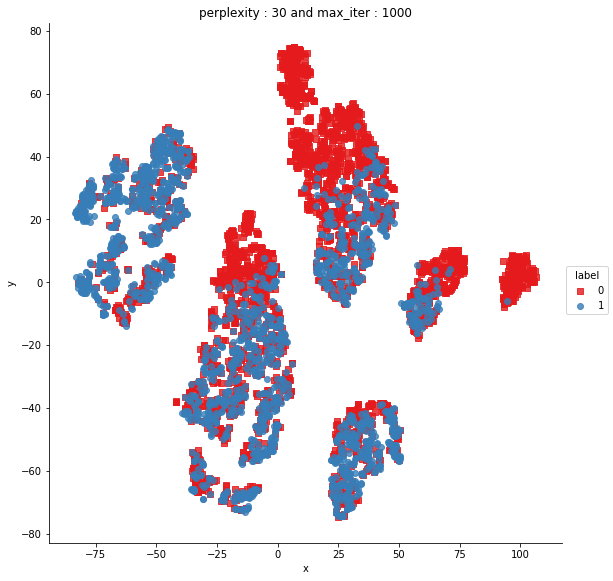

In [93]:
df_x = pd.DataFrame({'x':tsne2d[:,0], 'y':tsne2d[:,1] ,'label':y})

# draw the plot in appropriate place in the grid
sns.lmplot(data=df_x, x='x', y='y', hue='label', fit_reg=False, size=8,palette="Set1",markers=['s','o'])
plt.title("perplexity : {} and max_iter : {}".format(30, 1000))
plt.show()

In [94]:
from sklearn.manifold import TSNE
tsne3d = TSNE(
    n_components=3,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.035s...
[t-SNE] Computed neighbors for 5000 samples in 1.083s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.130446
[t-SNE] Computed conditional probabilities in 0.620s
[t-SNE] Iteration 50: error = 80.5298615, gradient norm = 0.0306586 (50 iterations in 20.915s)
[t-SNE] Iteration 100: error = 69.3777008, gradient norm = 0.0037944 (50 iterations in 9.439s)
[t-SNE] Iteration 150: error = 67.9726028, gradient norm = 0.0017517 (50 iterations in 8.561s)
[t-SNE] Iteration 200: error = 67.4098892, gradient norm = 0.0013384 (50 iterations in 8.576s)
[t-SNE] Iteration 250: error = 67.0977859, gradient norm = 0.000959

In [95]:
trace1 = go.Scatter3d(
    x=tsne3d[:,0],
    y=tsne3d[:,1],
    z=tsne3d[:,2],
    mode='markers',
    marker=dict(
        sizemode='diameter',
        color = y,
        colorscale = 'Portland',
        colorbar = dict(title = 'duplicate'),
        line=dict(color='rgb(255, 255, 255)'),
        opacity=0.75
    )
)

data=[trace1]
layout=dict(height=800, width=800, title='3d embedding with engineered features')
fig=dict(data=data, layout=layout)
py.iplot(fig, filename='3DBubble')

<h2> 3.6 Featurizing text data with tfidf </h2>

In [51]:
df = pd.read_csv(r"C:\Users\hp\Downloads\train.csv")

print("Number of data points:",df.shape[0])

Number of data points: 404290


In [96]:

df['question1'] = df['question1'].apply(lambda x: str(x))
df['question2'] = df['question2'].apply(lambda x: str(x))

In [97]:
#Checking whether there are any rows with null values
nan_rows = df[df.isnull().any(1)]
df = df.fillna('')
nan_rows = df[df.isnull().any(1)]


In [99]:
from sklearn.feature_extraction.text import TfidfVectorizer
vect = TfidfVectorizer(ngram_range=(1,1),max_features=20000)
sdf = vect.fit_transform(df['question1'])
                         

                         

In [100]:
sdf.shape

(404290, 20000)

In [101]:
vect_1 = TfidfVectorizer(ngram_range=(1,1),max_features=20000)
sdf_1 = vect.fit_transform(df['question2'])
                         


In [102]:
sdf_1.shape

(404290, 20000)

In [103]:
#prepro_features_train.csv (Simple Preprocessing Feartures)
#nlp_features_train.csv (NLP Features)
if os.path.isfile('nlp_features_train.csv'):
    dfnlp = pd.read_csv("nlp_features_train.csv",encoding='latin-1')
else:
    print("download nlp_features_train.csv from drive or run previous notebook")

if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    dfppro = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
else:
    print("download df_fe_without_preprocessing_train.csv from drive or run previous notebook")

In [104]:
dfnlp.head(1)

,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.99998,0.833319,0.999983,0.999983,...,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759


In [105]:
dfppro.head(1)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0


In [106]:
df.head(1)

,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.99998,0.833319,0.999983,0.999983,...,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759


In [107]:
df1 = dfnlp.drop(['qid1','qid2','question1','question2'],axis=1)
df2 = dfppro.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
df3 = df.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)

In [108]:
print(df1.shape)
print(df2.shape)
print(df3.shape)


(404290, 17)
(404290, 12)
(404290, 16)


In [109]:
temp = pd.concat([df1,df2],axis=1)
temp.shape

(404290, 29)

In [110]:
final_df = pd.concat([temp,df3],axis=1)
final_df.shape

(404290, 45)

In [112]:
final_df = final_df.drop(['id'],axis=1)

In [113]:
final_df.shape

(404290, 42)

In [114]:
final_df.head(1)

,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,0.99998,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,2.0,...,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759


In [132]:
X_tr = final_df.drop(['is_duplicate'],axis=1)

In [133]:
import scipy
com_df = scipy.sparse.csr_matrix(X_tr)

In [134]:
com_df.shape

(404290, 41)

In [130]:
import scipy.sparse
from scipy.sparse import coo_matrix, hstack
X_1 = scipy.sparse.hstack((sdf,sdf_1))

In [131]:
X_1.shape

(404290, 40000)

In [139]:
X=scipy.sparse.hstack((X_1,com_df))
X.shape

(404290, 40041)

<h2> 4. Train Test Split In [70:30 ] ratio </h2>

In [140]:
y_true = final_df['is_duplicate']
from sklearn.cross_validation import train_test_split
X_train,X_test, y_train, y_test = train_test_split(X, y_true, stratify=y_true, test_size=0.3)

In [141]:
print("Number of data points in train data :",X_train.shape)
print("Number of data points in test data :",X_test.shape)

Number of data points in train data : (283003, 40041)
Number of data points in test data : (121287, 40041)


In [143]:
from collections import Counter
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in train data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[1])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.6308025003268517 Class 1:  0.36919749967314835
---------- Distribution of output variable in train data ----------
Class 0:  0.3691986775169639 Class 1:  0.3691986775169639


<h2>4.1 Machine Learning Model </h2>

In [198]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

<h2> 4.3 Building a random model (Finding worst-case log-loss) </h2>

Log loss on Test Data using Random Model 0.8863093891142484


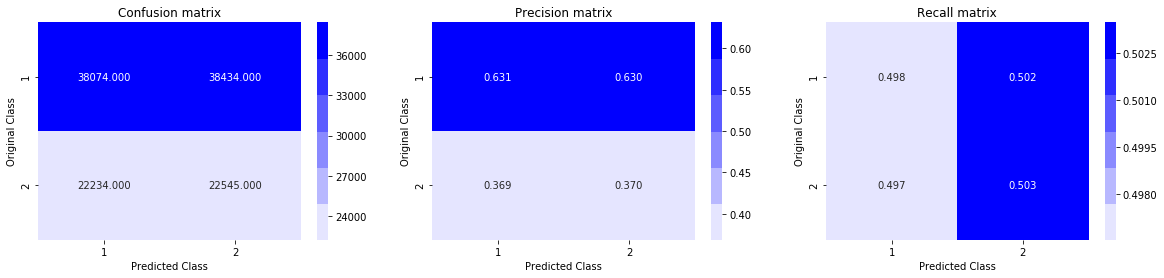

In [147]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
# we create a output array that has exactly same size as the CV data
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.metrics import confusion_matrix
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

<h2> 4.4 Logistic Regression with hyperparameter tuning </h2>

For values of alpha =  1e-05 The log loss is: 0.4579681097392341
For values of alpha =  0.0001 The log loss is: 0.4642297123252414
For values of alpha =  0.001 The log loss is: 0.457667961702451
For values of alpha =  0.01 The log loss is: 0.4483664797667305
For values of alpha =  0.1 The log loss is: 0.46257101940216855
For values of alpha =  1 The log loss is: 0.4947974606793787
For values of alpha =  10 The log loss is: 0.5432910601351946


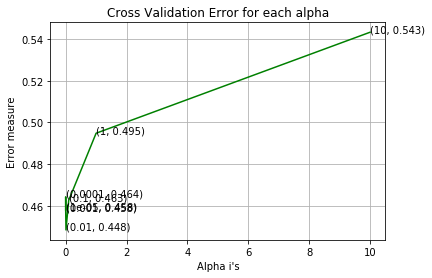

For values of best alpha =  0.01 The train log loss is: 0.44841691160455727
For values of best alpha =  0.01 The test log loss is: 0.4483664797667305
Total number of data points : 121287


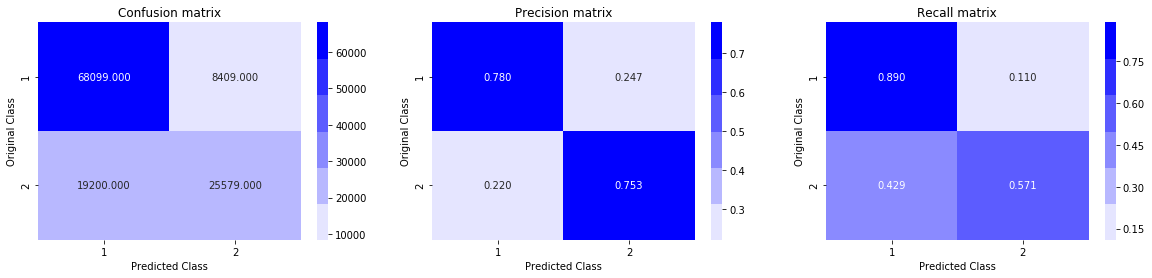

In [150]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

from sklearn.linear_model import SGDClassifier
from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import precision_recall_curve, auc, roc_curve


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

<h2> 4.5 Linear SVM with hyperparameter tuning </h2>

For values of alpha =  1e-05 The log loss is: 0.4565318113911515
For values of alpha =  0.0001 The log loss is: 0.45957773100302446
For values of alpha =  0.001 The log loss is: 0.4625151863141123
For values of alpha =  0.01 The log loss is: 0.4515359018718251
For values of alpha =  0.1 The log loss is: 0.46106983153689834
For values of alpha =  1 The log loss is: 0.4896300420849709
For values of alpha =  10 The log loss is: 0.5391488811735764


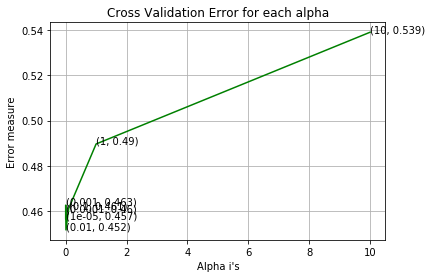

For values of best alpha =  0.01 The train log loss is: 0.44841691160455727
For values of best alpha =  0.01 The test log loss is: 0.4483664797667305
Total number of data points : 121287


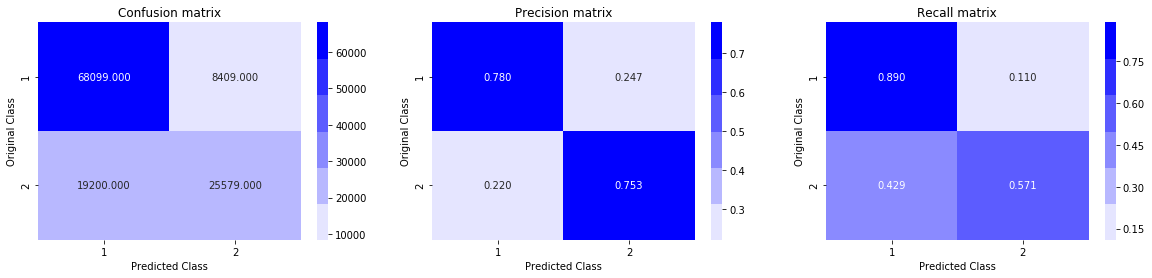

In [151]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.



log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

<h2> 4.6 XGboost with RanomizedSearchCV </h2>

In [160]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as st
from datetime import datetime

In [180]:
param_grid = {
        'silent': [False],
        'max_depth': [4],
        'learning_rate': [0.001, 0.01, 0.1, 0.2, 0,3],
        'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bytree': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bylevel': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'min_child_weight': [0.5, 1.0, 3.0, 5.0, 7.0, 10.0],
        'gamma': [0, 0.25, 0.5, 1.0],
        'reg_lambda': [0.1, 1.0, 5.0, 10.0, 50.0, 100.0],
        'n_estimators': [100]}
fit_params = {'eval_metric': 'logloss',
              'early_stopping_rounds': 10,
              'eval_set': [(X_train, y_train)]
              }

clf = xgb.XGBClassifier()

In [182]:
start = datetime.now()
rs_clf = RandomizedSearchCV(clf, param_grid, n_iter=20,
                            n_jobs=1, verbose=2, cv=2,
                            fit_params=fit_params,
                            scoring='neg_log_loss', refit=False, random_state=42)

print(datetime.now()-start)

0:00:00


In [186]:
rs_clf.fit(X_train, y_train)

Fitting 2 folds for each of 20 candidates, totalling 40 fits
[CV] subsample=0.7, silent=False, reg_lambda=50.0, n_estimators=100, min_child_weight=5.0, max_depth=4, learning_rate=0.001, gamma=0.5, colsample_bytree=0.6, colsample_bylevel=0.7 
[0]	validation_0-logloss:0.692762
Will train until validation_0-logloss hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.692372
[2]	validation_0-logloss:0.692059
[3]	validation_0-logloss:0.69167
[4]	validation_0-logloss:0.691287
[5]	validation_0-logloss:0.690903
[6]	validation_0-logloss:0.690522
[7]	validation_0-logloss:0.690135
[8]	validation_0-logloss:0.689754
[9]	validation_0-logloss:0.689372
[10]	validation_0-logloss:0.689
[11]	validation_0-logloss:0.688589
[12]	validation_0-logloss:0.688183
[13]	validation_0-logloss:0.687797
[14]	validation_0-logloss:0.687407
[15]	validation_0-logloss:0.68705
[16]	validation_0-logloss:0.686701
[17]	validation_0-logloss:0.686329
[18]	validation_0-logloss:0.685964
[19]	validation_0-logloss:0.685658
[20]	

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.7min remaining:    0.0s


[0]	validation_0-logloss:0.692768
Will train until validation_0-logloss hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.692367
[2]	validation_0-logloss:0.691972
[3]	validation_0-logloss:0.691583
[4]	validation_0-logloss:0.6912
[5]	validation_0-logloss:0.690803
[6]	validation_0-logloss:0.690407
[7]	validation_0-logloss:0.690012
[8]	validation_0-logloss:0.689623
[9]	validation_0-logloss:0.689255
[10]	validation_0-logloss:0.688866
[11]	validation_0-logloss:0.688525
[12]	validation_0-logloss:0.688161
[13]	validation_0-logloss:0.687755
[14]	validation_0-logloss:0.687348
[15]	validation_0-logloss:0.686987
[16]	validation_0-logloss:0.686681
[17]	validation_0-logloss:0.686311
[18]	validation_0-logloss:0.685923
[19]	validation_0-logloss:0.685538
[20]	validation_0-logloss:0.685187
[21]	validation_0-logloss:0.684819
[22]	validation_0-logloss:0.684431
[23]	validation_0-logloss:0.684077
[24]	validation_0-logloss:0.68372
[25]	validation_0-logloss:0.683429
[26]	validation_0-logloss:0.68303
[

[8]	validation_0-logloss:0.661568
[9]	validation_0-logloss:0.658231
[10]	validation_0-logloss:0.654823
[11]	validation_0-logloss:0.651684
[12]	validation_0-logloss:0.648521
[13]	validation_0-logloss:0.645329
[14]	validation_0-logloss:0.642133
[15]	validation_0-logloss:0.639055
[16]	validation_0-logloss:0.636641
[17]	validation_0-logloss:0.633459
[18]	validation_0-logloss:0.630523
[19]	validation_0-logloss:0.627837
[20]	validation_0-logloss:0.625676
[21]	validation_0-logloss:0.62349
[22]	validation_0-logloss:0.621395
[23]	validation_0-logloss:0.618858
[24]	validation_0-logloss:0.615887
[25]	validation_0-logloss:0.61321
[26]	validation_0-logloss:0.610426
[27]	validation_0-logloss:0.607925
[28]	validation_0-logloss:0.605321
[29]	validation_0-logloss:0.602806
[30]	validation_0-logloss:0.600216
[31]	validation_0-logloss:0.598375
[32]	validation_0-logloss:0.595619
[33]	validation_0-logloss:0.59316
[34]	validation_0-logloss:0.591282
[35]	validation_0-logloss:0.589475
[36]	validation_0-logloss

[81]	validation_0-logloss:0.661737
[82]	validation_0-logloss:0.661376
[83]	validation_0-logloss:0.661007
[84]	validation_0-logloss:0.660655
[85]	validation_0-logloss:0.660316
[86]	validation_0-logloss:0.659961
[87]	validation_0-logloss:0.659608
[88]	validation_0-logloss:0.659267
[89]	validation_0-logloss:0.658916
[90]	validation_0-logloss:0.65856
[91]	validation_0-logloss:0.658198
[92]	validation_0-logloss:0.657844
[93]	validation_0-logloss:0.657481
[94]	validation_0-logloss:0.657122
[95]	validation_0-logloss:0.656763
[96]	validation_0-logloss:0.656399
[97]	validation_0-logloss:0.656048
[98]	validation_0-logloss:0.655687
[99]	validation_0-logloss:0.655338
[CV]  subsample=0.7, silent=False, reg_lambda=5.0, n_estimators=100, min_child_weight=0.5, max_depth=4, learning_rate=0.001, gamma=0, colsample_bytree=1.0, colsample_bylevel=0.6, total= 1.4min
[CV] subsample=0.7, silent=False, reg_lambda=5.0, n_estimators=100, min_child_weight=0.5, max_depth=4, learning_rate=0.001, gamma=0, colsample_

[91]	validation_0-logloss:0.356732
[92]	validation_0-logloss:0.356526
[93]	validation_0-logloss:0.356342
[94]	validation_0-logloss:0.355927
[95]	validation_0-logloss:0.35547
[96]	validation_0-logloss:0.355218
[97]	validation_0-logloss:0.354849
[98]	validation_0-logloss:0.35466
[99]	validation_0-logloss:0.35444
[CV]  subsample=1.0, silent=False, reg_lambda=100.0, n_estimators=100, min_child_weight=10.0, max_depth=4, learning_rate=0.1, gamma=0, colsample_bytree=0.6, colsample_bylevel=0.7, total= 1.4min
[CV] subsample=1.0, silent=False, reg_lambda=100.0, n_estimators=100, min_child_weight=10.0, max_depth=4, learning_rate=0.1, gamma=0, colsample_bytree=0.6, colsample_bylevel=0.7 
[0]	validation_0-logloss:0.655052
Will train until validation_0-logloss hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.624758
[2]	validation_0-logloss:0.599125
[3]	validation_0-logloss:0.575664
[4]	validation_0-logloss:0.555026
[5]	validation_0-logloss:0.53858
[6]	validation_0-logloss:0.523418
[7]	valida

[0]	validation_0-logloss:0.692771
Will train until validation_0-logloss hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.692495
[2]	validation_0-logloss:0.692186
[3]	validation_0-logloss:0.691882
[4]	validation_0-logloss:0.691579
[5]	validation_0-logloss:0.691176
[6]	validation_0-logloss:0.69077
[7]	validation_0-logloss:0.690464
[8]	validation_0-logloss:0.690071
[9]	validation_0-logloss:0.689681
[10]	validation_0-logloss:0.689377
[11]	validation_0-logloss:0.68898
[12]	validation_0-logloss:0.688581
[13]	validation_0-logloss:0.688188
[14]	validation_0-logloss:0.687768
[15]	validation_0-logloss:0.687432
[16]	validation_0-logloss:0.687066
[17]	validation_0-logloss:0.686687
[18]	validation_0-logloss:0.686284
[19]	validation_0-logloss:0.685902
[20]	validation_0-logloss:0.685525
[21]	validation_0-logloss:0.685254
[22]	validation_0-logloss:0.684862
[23]	validation_0-logloss:0.684517
[24]	validation_0-logloss:0.684154
[25]	validation_0-logloss:0.68377
[26]	validation_0-logloss:0.683403


[9]	validation_0-logloss:0.477966
[10]	validation_0-logloss:0.467604
[11]	validation_0-logloss:0.459401
[12]	validation_0-logloss:0.45161
[13]	validation_0-logloss:0.444902
[14]	validation_0-logloss:0.43827
[15]	validation_0-logloss:0.432875
[16]	validation_0-logloss:0.4271
[17]	validation_0-logloss:0.422659
[18]	validation_0-logloss:0.418244
[19]	validation_0-logloss:0.414385
[20]	validation_0-logloss:0.410666
[21]	validation_0-logloss:0.407846
[22]	validation_0-logloss:0.405252
[23]	validation_0-logloss:0.402759
[24]	validation_0-logloss:0.400038
[25]	validation_0-logloss:0.397453
[26]	validation_0-logloss:0.395205
[27]	validation_0-logloss:0.393036
[28]	validation_0-logloss:0.391117
[29]	validation_0-logloss:0.389397
[30]	validation_0-logloss:0.387766
[31]	validation_0-logloss:0.386692
[32]	validation_0-logloss:0.385213
[33]	validation_0-logloss:0.383437
[34]	validation_0-logloss:0.382283
[35]	validation_0-logloss:0.381118
[36]	validation_0-logloss:0.37998
[37]	validation_0-logloss:

[20]	validation_0-logloss:0.416998
[21]	validation_0-logloss:0.412326
[22]	validation_0-logloss:0.409733
[23]	validation_0-logloss:0.406947
[24]	validation_0-logloss:0.404735
[25]	validation_0-logloss:0.402693
[26]	validation_0-logloss:0.401035
[27]	validation_0-logloss:0.399137
[28]	validation_0-logloss:0.396213
[29]	validation_0-logloss:0.394578
[30]	validation_0-logloss:0.392688
[31]	validation_0-logloss:0.391166
[32]	validation_0-logloss:0.389397
[33]	validation_0-logloss:0.388256
[34]	validation_0-logloss:0.386498
[35]	validation_0-logloss:0.385305
[36]	validation_0-logloss:0.38431
[37]	validation_0-logloss:0.383356
[38]	validation_0-logloss:0.382602
[39]	validation_0-logloss:0.380978
[40]	validation_0-logloss:0.379915
[41]	validation_0-logloss:0.379016
[42]	validation_0-logloss:0.377919
[43]	validation_0-logloss:0.377004
[44]	validation_0-logloss:0.376461
[45]	validation_0-logloss:0.375754
[46]	validation_0-logloss:0.374493
[47]	validation_0-logloss:0.373941
[48]	validation_0-log

[0]	validation_0-logloss:0.62307
Will train until validation_0-logloss hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.570834
[2]	validation_0-logloss:0.540731
[3]	validation_0-logloss:0.509181
[4]	validation_0-logloss:0.490291
[5]	validation_0-logloss:0.470228
[6]	validation_0-logloss:0.454875
[7]	validation_0-logloss:0.441649
[8]	validation_0-logloss:0.431988
[9]	validation_0-logloss:0.422823
[10]	validation_0-logloss:0.415431
[11]	validation_0-logloss:0.408967
[12]	validation_0-logloss:0.40169
[13]	validation_0-logloss:0.397795
[14]	validation_0-logloss:0.392508
[15]	validation_0-logloss:0.389308
[16]	validation_0-logloss:0.387127
[17]	validation_0-logloss:0.384748
[18]	validation_0-logloss:0.382595
[19]	validation_0-logloss:0.380902
[20]	validation_0-logloss:0.377747
[21]	validation_0-logloss:0.376161
[22]	validation_0-logloss:0.374852
[23]	validation_0-logloss:0.373596
[24]	validation_0-logloss:0.372342
[25]	validation_0-logloss:0.371251
[26]	validation_0-logloss:0.369137

[9]	validation_0-logloss:22.2198
[10]	validation_0-logloss:22.2198
Stopping. Best iteration:
[0]	validation_0-logloss:0.536192

[CV]  subsample=1.0, silent=False, reg_lambda=1.0, n_estimators=100, min_child_weight=10.0, max_depth=4, learning_rate=3, gamma=0.5, colsample_bytree=0.4, colsample_bylevel=0.7, total=  12.6s
[CV] subsample=1.0, silent=False, reg_lambda=1.0, n_estimators=100, min_child_weight=10.0, max_depth=4, learning_rate=3, gamma=0.5, colsample_bytree=0.4, colsample_bylevel=0.7 
[0]	validation_0-logloss:0.549551
Will train until validation_0-logloss hasn't improved in 10 rounds.
[1]	validation_0-logloss:8.34583
[2]	validation_0-logloss:3.30322
[3]	validation_0-logloss:5.41032
[4]	validation_0-logloss:7.45269
[5]	validation_0-logloss:12.018
[6]	validation_0-logloss:14.6407
[7]	validation_0-logloss:22.8645
[8]	validation_0-logloss:22.8645
[9]	validation_0-logloss:22.8645
[10]	validation_0-logloss:22.8645
Stopping. Best iteration:
[0]	validation_0-logloss:0.549551

[CV]  subs

[82]	validation_0-logloss:0.353687
[83]	validation_0-logloss:0.353443
[84]	validation_0-logloss:0.353274
[85]	validation_0-logloss:0.352958
[86]	validation_0-logloss:0.35267
[87]	validation_0-logloss:0.352424
[88]	validation_0-logloss:0.352056
[89]	validation_0-logloss:0.351893
[90]	validation_0-logloss:0.35174
[91]	validation_0-logloss:0.351439
[92]	validation_0-logloss:0.351033
[93]	validation_0-logloss:0.350805
[94]	validation_0-logloss:0.350646
[95]	validation_0-logloss:0.350487
[96]	validation_0-logloss:0.350202
[97]	validation_0-logloss:0.349927
[98]	validation_0-logloss:0.349491
[99]	validation_0-logloss:0.348966
[CV]  subsample=0.5, silent=False, reg_lambda=0.1, n_estimators=100, min_child_weight=10.0, max_depth=4, learning_rate=0.1, gamma=0.25, colsample_bytree=0.7, colsample_bylevel=0.7, total= 1.3min
[CV] subsample=0.8, silent=False, reg_lambda=50.0, n_estimators=100, min_child_weight=0.5, max_depth=4, learning_rate=0.01, gamma=1.0, colsample_bytree=0.9, colsample_bylevel=0.

[93]	validation_0-logloss:0.486822
[94]	validation_0-logloss:0.485676
[95]	validation_0-logloss:0.48453
[96]	validation_0-logloss:0.483398
[97]	validation_0-logloss:0.482284
[98]	validation_0-logloss:0.48123
[99]	validation_0-logloss:0.480155
[CV]  subsample=0.8, silent=False, reg_lambda=50.0, n_estimators=100, min_child_weight=0.5, max_depth=4, learning_rate=0.01, gamma=1.0, colsample_bytree=0.9, colsample_bylevel=0.8, total= 1.8min
[CV] subsample=0.6, silent=False, reg_lambda=100.0, n_estimators=100, min_child_weight=7.0, max_depth=4, learning_rate=0.2, gamma=1.0, colsample_bytree=0.5, colsample_bylevel=0.9 
[0]	validation_0-logloss:0.62178
Will train until validation_0-logloss hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.573174
[2]	validation_0-logloss:0.535293
[3]	validation_0-logloss:0.509442
[4]	validation_0-logloss:0.486063
[5]	validation_0-logloss:0.470225
[6]	validation_0-logloss:0.459098
[7]	validation_0-logloss:0.446062
[8]	validation_0-logloss:0.432076
[9]	valid

[0]	validation_0-logloss:0.657778
Will train until validation_0-logloss hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.627952
[2]	validation_0-logloss:0.600469
[3]	validation_0-logloss:0.572978
[4]	validation_0-logloss:0.550518
[5]	validation_0-logloss:0.53306
[6]	validation_0-logloss:0.51757
[7]	validation_0-logloss:0.503884
[8]	validation_0-logloss:0.49396
[9]	validation_0-logloss:0.484
[10]	validation_0-logloss:0.473649
[11]	validation_0-logloss:0.465264
[12]	validation_0-logloss:0.459283
[13]	validation_0-logloss:0.453678
[14]	validation_0-logloss:0.448277
[15]	validation_0-logloss:0.443707
[16]	validation_0-logloss:0.436292
[17]	validation_0-logloss:0.429163
[18]	validation_0-logloss:0.424579
[19]	validation_0-logloss:0.418783
[20]	validation_0-logloss:0.415064
[21]	validation_0-logloss:0.412387
[22]	validation_0-logloss:0.408597
[23]	validation_0-logloss:0.405788
[24]	validation_0-logloss:0.402425
[25]	validation_0-logloss:0.400104
[26]	validation_0-logloss:0.398263
[27

[9]	validation_0-logloss:0.693147
[10]	validation_0-logloss:0.693147
Stopping. Best iteration:
[0]	validation_0-logloss:0.693147

[CV]  subsample=0.7, silent=False, reg_lambda=5.0, n_estimators=100, min_child_weight=1.0, max_depth=4, learning_rate=0, gamma=1.0, colsample_bytree=0.4, colsample_bylevel=0.5, total=  13.3s
[CV] subsample=0.7, silent=False, reg_lambda=5.0, n_estimators=100, min_child_weight=1.0, max_depth=4, learning_rate=0, gamma=1.0, colsample_bytree=0.4, colsample_bylevel=0.5 
[0]	validation_0-logloss:0.693147
Will train until validation_0-logloss hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.693147
[2]	validation_0-logloss:0.693147
[3]	validation_0-logloss:0.693147
[4]	validation_0-logloss:0.693147
[5]	validation_0-logloss:0.693147
[6]	validation_0-logloss:0.693147
[7]	validation_0-logloss:0.693147
[8]	validation_0-logloss:0.693147
[9]	validation_0-logloss:0.693147
[10]	validation_0-logloss:0.693147
Stopping. Best iteration:
[0]	validation_0-logloss:0.693147


[32]	validation_0-logloss:0.680071
[33]	validation_0-logloss:0.679691
[34]	validation_0-logloss:0.679305
[35]	validation_0-logloss:0.678935
[36]	validation_0-logloss:0.678557
[37]	validation_0-logloss:0.678167
[38]	validation_0-logloss:0.677783
[39]	validation_0-logloss:0.677421
[40]	validation_0-logloss:0.677042
[41]	validation_0-logloss:0.676685
[42]	validation_0-logloss:0.676409
[43]	validation_0-logloss:0.676012
[44]	validation_0-logloss:0.675631
[45]	validation_0-logloss:0.675256
[46]	validation_0-logloss:0.674875
[47]	validation_0-logloss:0.674511
[48]	validation_0-logloss:0.674143
[49]	validation_0-logloss:0.67377
[50]	validation_0-logloss:0.673408
[51]	validation_0-logloss:0.673045
[52]	validation_0-logloss:0.672692
[53]	validation_0-logloss:0.67233
[54]	validation_0-logloss:0.671966
[55]	validation_0-logloss:0.671575
[56]	validation_0-logloss:0.671241
[57]	validation_0-logloss:0.67085
[58]	validation_0-logloss:0.670471
[59]	validation_0-logloss:0.670188
[60]	validation_0-loglo

[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed: 39.7min finished


RandomizedSearchCV(cv=2, error_score='raise',
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
          fit_params={'eval_metric': 'logloss', 'early_stopping_rounds': 10, 'eval_set': [(<283003x40041 sparse matrix of type '<class 'numpy.float64'>'
	with 15969988 stored elements in Compressed Sparse Row format>, 62969     1
61666     0
161174    1
159512    0
37887     0
117443    0
106772    0
219847  ...
331795    1
54125     1
380805    1
404172    0
Name: is_duplicate, Length: 283003, dtype: int64)]},
          iid=True, n_iter=20, n_jobs=1,
          param_distributions={'silent': [False], 'max_depth': [4], 'learning_rate': [0.0

In [187]:
best_score = rs_clf.best_score_
best_params = rs_clf.best_params_

In [188]:
print("Best score: {}".format(best_score))
print("Best params: ")
for param_name in sorted(best_params.keys()):
    print('%s: %r' % (param_name, best_params[param_name]))

Best score: -0.3383749954223612
Best params: 
colsample_bylevel: 0.6
colsample_bytree: 0.6
gamma: 1.0
learning_rate: 0.2
max_depth: 4
min_child_weight: 0.5
n_estimators: 100
reg_lambda: 10.0
silent: False
subsample: 0.5


In [194]:
clf = xgb.XGBClassifier(max_depth=4,learning_rate=0.2,objective='binary:logistic',min_child_weight=0.5,
                        subsample=0.5,colsample_bytree = 0.6,colsample_bylevel = 0.6)
                        
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)
predict_y = sig_clf.predict_proba(X_test)
log_loss(y_test, predict_y, eps=1e-15)
print("The log loss is:",log_loss(y_test, predict_y,  eps=1e-15))

The log loss is: 0.34266595499938407


Total number of data points : 121287


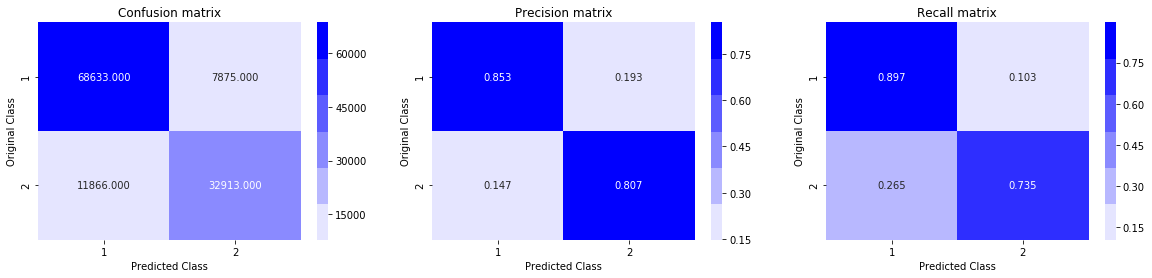

In [195]:
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

<h4> Conclusion </h4>
<p> After Running Various Model the best score (log_loss) is 0.34 using XGboostClassifier<p>

<!DOCTYPE html>
<html>
<head>
<style>
table {
    font-family: arial, sans-serif;
    border-collapse: collapse;
    width: 100%;
}

td, th {
    border: 1px solid #dddddd;
    text-align: left;
    padding: 8px;
}

tr:nth-child(even) {
    background-color: #dddddd;
}
</style>
</head>
<body>

<h2>Summary </h2>

<table>
  <tr>
    <th>Model</th>
    <th>Score(Log-loss)</th>
    
  </tr>
  <tr>
    <td>Random Model</td>
    <td>0.88</td>
    
  </tr>
  <tr>
    <td>Logistic Regression</td>
    <td>0.44</td>
    
  </tr>
  <tr>
    <td>Linear SVM</td>
    <td>0.44</td>
    
  </tr>
  <tr>
    <td>XGboost Classifier</td>
    <td>0.34</td>
    
  </tr>
 
</table>

</body>
</html>
